# GNN example

### Reading in a polarizability dataset

Installing pytorch extension libraries is not entirely straightforward
```
$ pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
```

In [1]:
from pathlib import Path

import numpy as np
import torch
from tqdm import tqdm

import ramannoodle.io.vasp as vasp_io
from ramannoodle.io.io_utils import pathify_as_list
from ramannoodle.exceptions import InvalidFileException

import matplotlib
from matplotlib import pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["lines.linewidth"] = 1.5

chosen_device = 'mps'
torch.set_default_device(chosen_device)

from torch.utils.data import DataLoader, random_split



In [2]:
import ramannoodle.io.vasp as vasp_io

import glob

train_dataset = vasp_io.outcar.read_polarizability_dataset(
    list(glob.glob("/Volumes/Untitled/TiO2_eps/train/*ps*/scratch/OUTCAR"))
)
validation_dataset = vasp_io.outcar.read_polarizability_dataset(
    list(glob.glob("/Volumes/Untitled/TiO2_eps/validation/*ps*/scratch/OUTCAR"))
)

100%|██████████| 100/100 [00:00<00:00, 117.27files/s]


In [4]:
vasp_io.vasprun.read_structure_and_polarizability("data/STO/vasprun.xml")

(array([[11.37684345,  0.        ,  0.        ],
        [ 0.        , 11.37684345,  0.        ],
        [ 0.        ,  0.        ,  9.6045742 ]]),
 [22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  22,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8],
 array([[0.16666667, 0.16666667, 0.5       ],
        [0.16666667, 0.5       , 0.5       ],
        [0.16666667, 0.83333331, 0.5       ],
        [0.5       , 0.16666667, 0.5       ],
        [0.5       , 0.5       , 0.5       ],
        [0.5       , 0.83333331, 0.5       ]

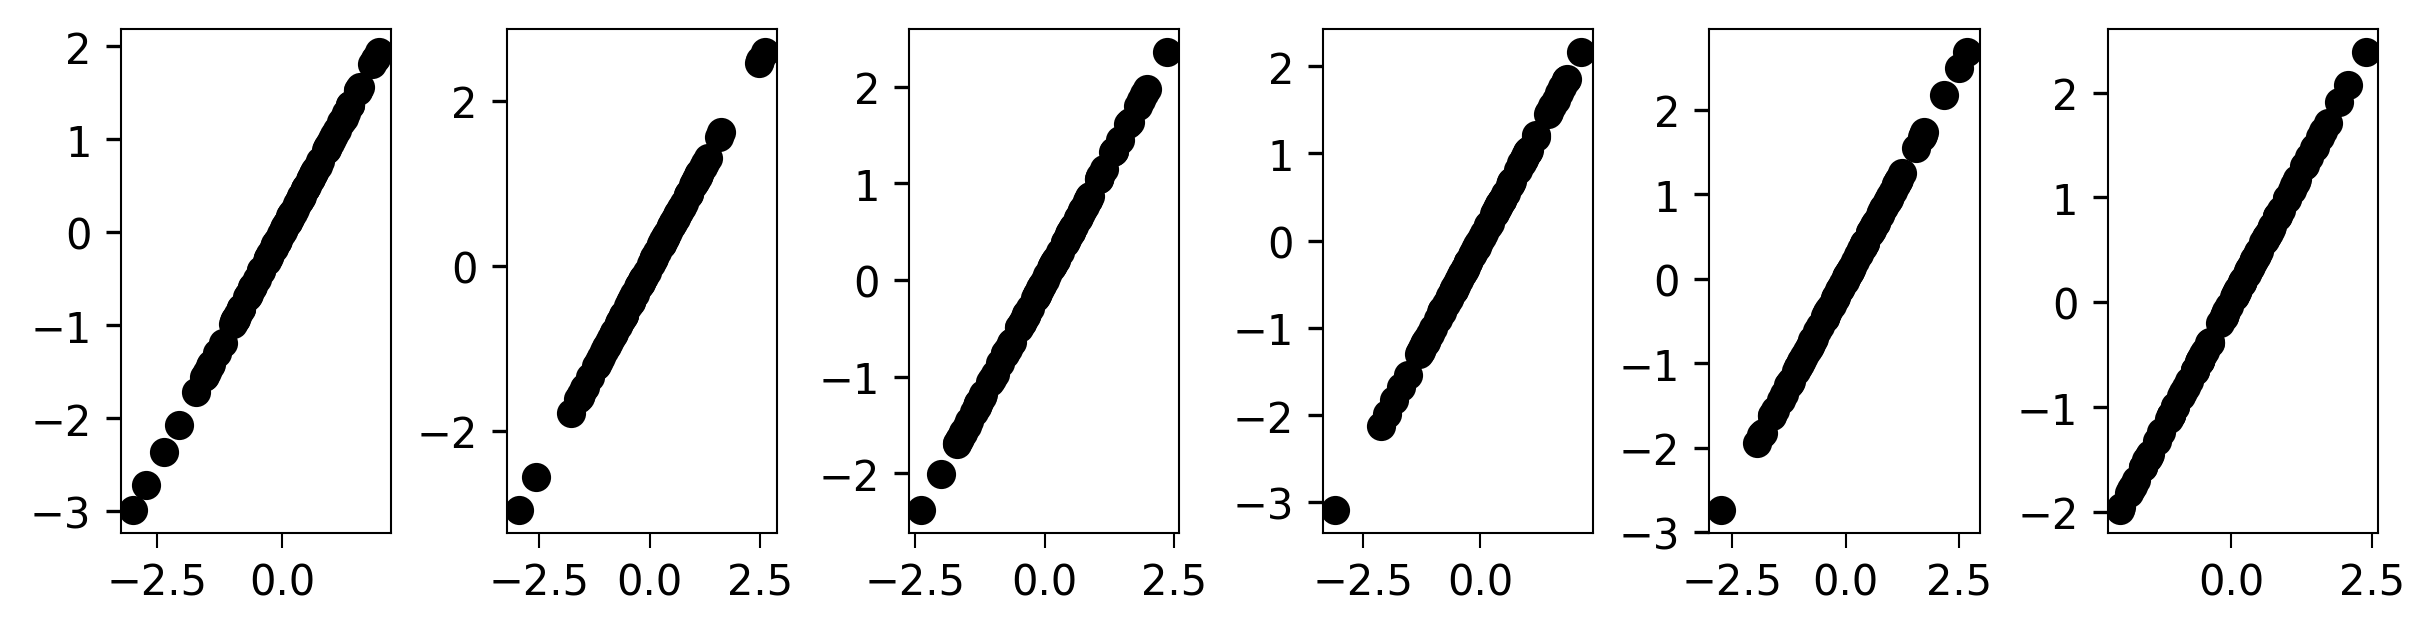

In [3]:
fig = plt.figure(constrained_layout=True, figsize=(8, 2))
gs = fig.add_gridspec(1, 6, wspace=0)
axes = gs.subplots()
loader = DataLoader(train_dataset, batch_size = 50)

for lattice, atomic_numbers, positions, true_polarizability  in loader:
    for i in range(6): 
        axis = axes[i]  # type: ignore
        axis.scatter(true_polarizability[:,i].cpu(), true_polarizability[:,i].cpu(), color="black")

In [9]:
import warnings
warnings.filterwarnings("error")

from torch import Tensor
from ramannoodle.polarizability.gnn import PotGNN

validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=True, generator=torch.Generator(device=chosen_device))

ref_structure = vasp_io.poscar.read_ref_structure("data/TiO2/POSCAR")

model = PotGNN(
    ref_structure,
    size_node_embedding=5,
    size_edge_embedding=14,
    num_message_passes=4,
    cutoff = 3,
)

model.to(chosen_device)

def init_biases(m):
    if isinstance(m,torch.nn.Linear):
        torch.nn.init.uniform_(m.bias,-0.5,0.5)
def init_weights(m):
    if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Embedding):
        torch.nn.init.normal_(m.weight, mean = 0, std = 1)

model.apply(init_biases)
model.apply(init_weights)

def train(batch_size: int, optimizer, criterion) -> dict:

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=chosen_device)) 
    default_device = torch.get_default_device()

    model.train()

    train_losses = []
    validation_losses = []
    
    for lattice, atomic_numbers, position, polarizability in train_loader:  
        
        out = model.forward(lattice.to(default_device), atomic_numbers.to(default_device), position.to(default_device))  
        loss = criterion(out, polarizability)
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad() 
        train_losses.append(float(loss))

    model.eval()
    validation_losses = []
    validation_vars = []
    for lattice, atomic_numbers, position, polarizability  in validation_loader:
        out = model.forward(lattice.to(default_device), atomic_numbers.to(default_device), position.to(default_device))  
        loss = criterion(out, polarizability)
        validation_losses.append(float(loss))
        validation_vars.append(torch.var(out,dim=0).detach().cpu().numpy().copy())
    
    result = {
        "train_loss" : float(np.mean(train_losses)), 
        "validation_loss" : float(np.mean(validation_losses)),
        "validation_var" : np.mean(validation_vars, axis = 0),
    }
    return result


In [10]:
training_losses = []
validation_losses = []
validation_vars = []

In [11]:
criterion = torch.nn.MSELoss()

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
from tqdm import trange
print(len(train_dataset))
with trange(100) as t:
    for epoch in t:
        result = train(100, optimizer, criterion)
        t.set_postfix(
            training_loss=result['train_loss'], 
            validation_loss=result['validation_loss'], 
            validation_var = np.array2string(result['validation_var'], precision = 2)
        )
        training_losses.append(result['train_loss'])
        validation_losses.append(result['validation_loss'])
        validation_vars.append(result['validation_var'])
        if result['validation_loss'] < 0.15:
            break 


99


  3%|▎         | 3/100 [00:54<29:25, 18.20s/it, training_loss=0.999, validation_loss=5.01, validation_var=[6.95e-04 2.80e-04 1.09e-03 4.16e-06 1.07e-04 2.41e-04]]


KeyboardInterrupt: 

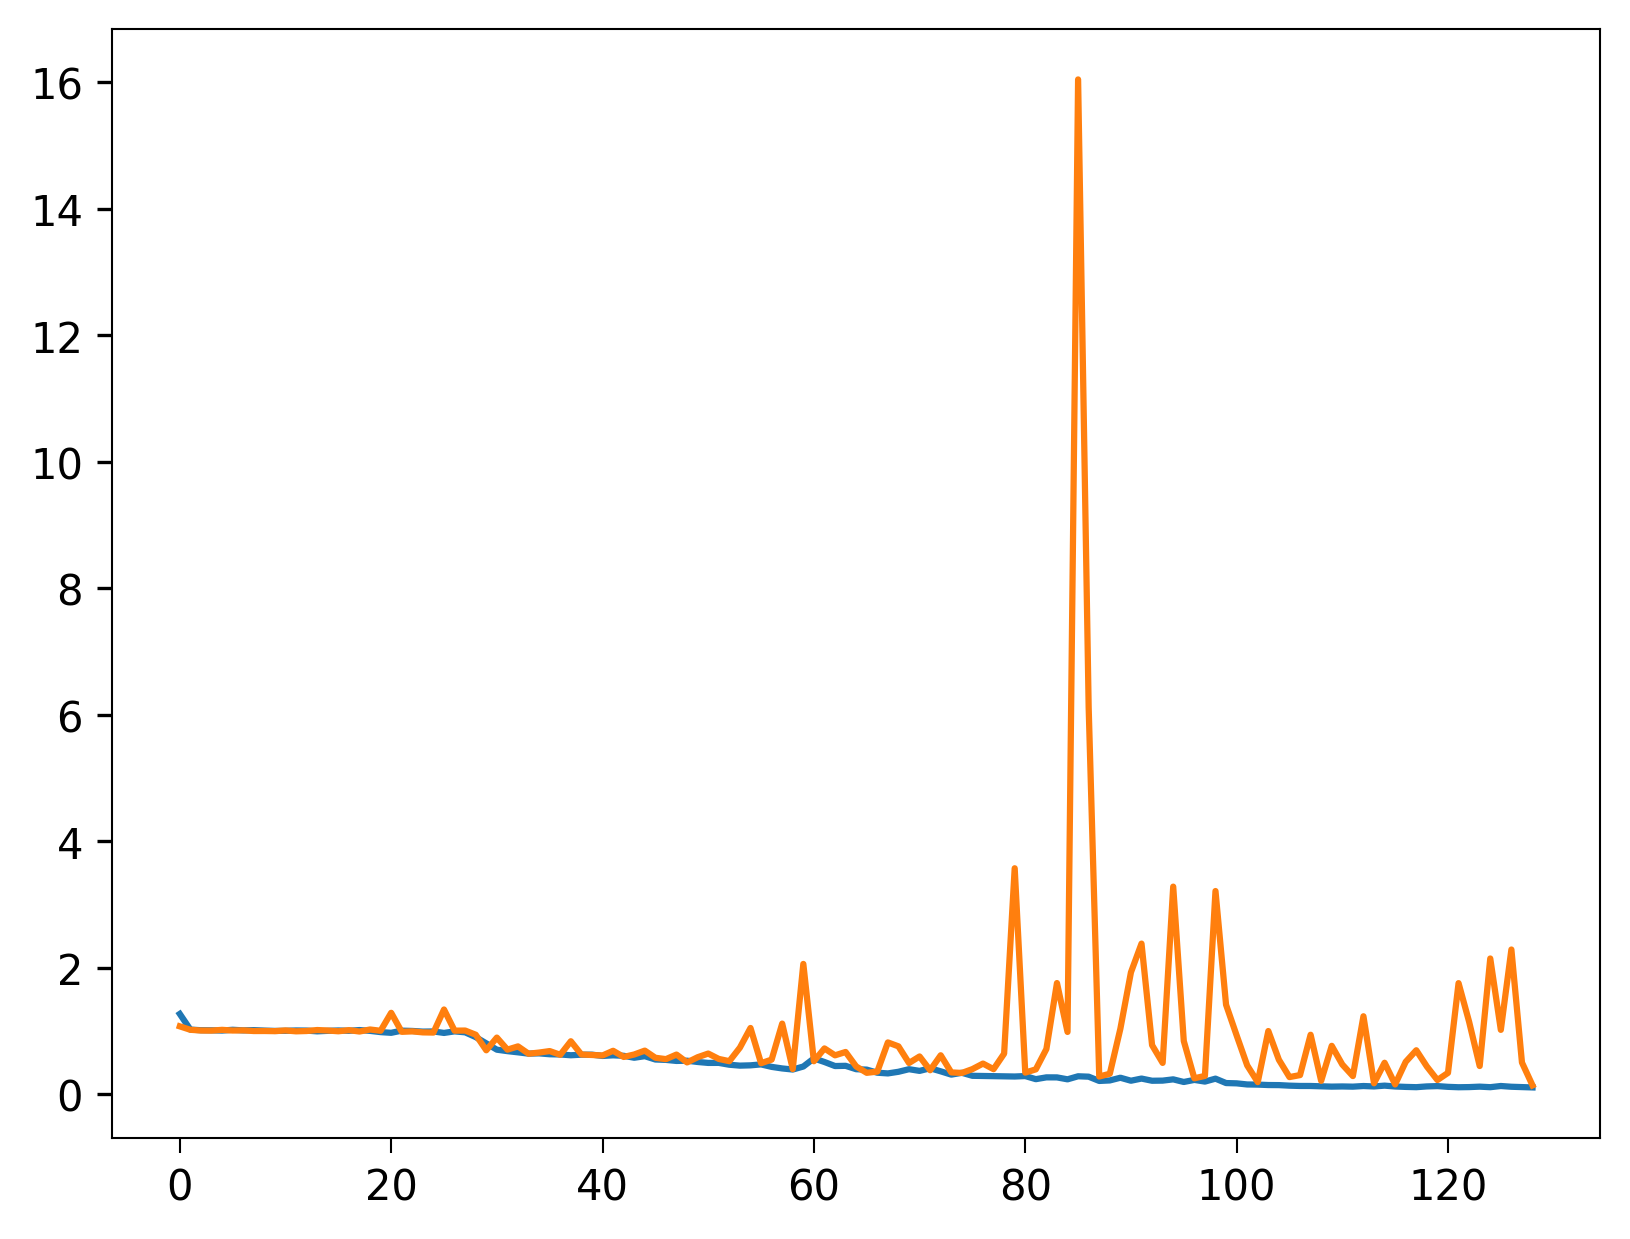

In [10]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(training_losses)
axis.plot(validation_losses)

In [27]:
import ramannoodle.io.vasp as vasp_io
from torch import Tensor
from ramannoodle.polarizability.gnn import PotGNN

ref_structure = vasp_io.poscar.read_ref_structure("data/TiO2/POSCAR")
lattice = torch.tensor([ref_structure.lattice]).float()
atomic_numbers = torch.tensor([ref_structure.atomic_numbers], dtype=torch.int)
positions = torch.tensor([ref_structure.positions]).float()

model.eval()

ds = torch.linspace(0.40,0.60,300)
result = []
for d in ds:
    positions[0][4][0] = d
    result.append(model(lattice, atomic_numbers, positions)[0].detach().numpy())
result = np.array(result)

fig = plt.figure(constrained_layout=True, figsize=(10, 3))
gs = fig.add_gridspec(1, 6, wspace=0)
axes = gs.subplots()

for i in range(6): 
    axis = axes[i]  # type: ignore
    axis.plot(ds, result[:,i])
    #axis.set_yticks([])

IndexError: index out of range in self

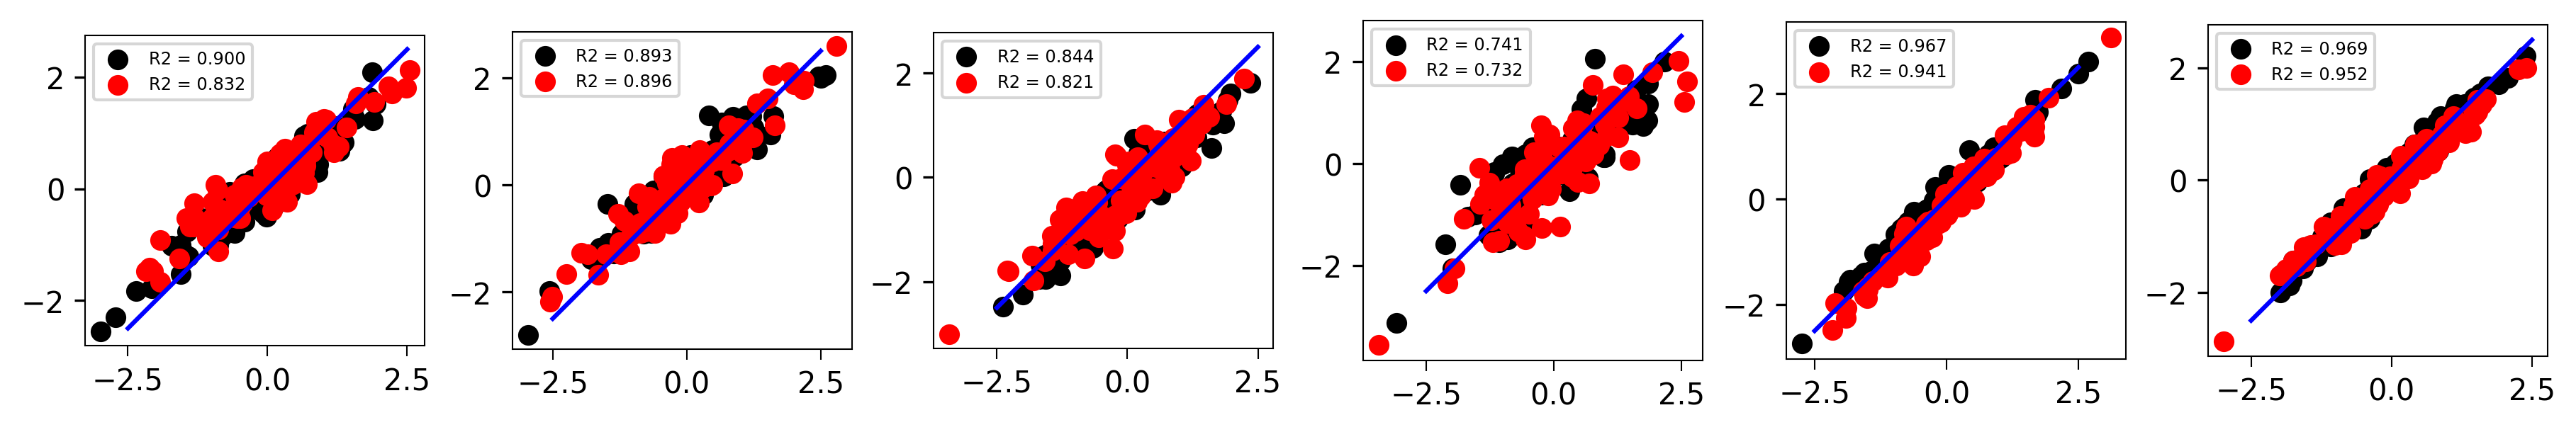

In [11]:
import torcheval
import torcheval.metrics

fig = plt.figure(constrained_layout=True, figsize=(12, 2))
gs = fig.add_gridspec(1, 6, wspace=0)
axes = gs.subplots()
plot_train_loader = DataLoader(train_dataset, batch_size = 100)
plot_validation_loader = DataLoader(validation_dataset, batch_size = 100)

model.eval()

for i in range(6): 
    axis = axes[i]  # type: ignore
    for lattice, atomic_numbers, positions, true_polarizability  in plot_train_loader:
        predicted_polarizability = model(lattice, atomic_numbers, positions).detach()
        loss = criterion(true_polarizability[:,i], predicted_polarizability[:,i])
        metric = torcheval.metrics.R2Score()
        metric.update(predicted_polarizability[:,i], true_polarizability[:,i])
        R2 = metric.compute()
        axis.scatter(
            true_polarizability[:,i], predicted_polarizability[:,i], color="black", 
            label = f"R2 = {R2:.3f}"
        )
    for lattice, atomic_numbers, positions, true_polarizability  in plot_validation_loader:
        predicted_polarizability = model(lattice, atomic_numbers, positions).detach()
        loss = criterion(true_polarizability[:,i], predicted_polarizability[:,i])
        metric = torcheval.metrics.R2Score()
        metric.update(predicted_polarizability[:,i], true_polarizability[:,i])
        R2 = metric.compute()
        axis.scatter(
            true_polarizability[:,i], predicted_polarizability[:,i], color="red",
            label = f"R2 = {R2:.3f}"
        )
        

    axis.set_aspect(1)
    axis.plot([-2.5,2.5],[-2.5,2.5],color = "blue", zorder = 5)
    l = axis.legend(fontsize ="xx-small")

In [97]:
modules = [m for m in model.modules() if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Embedding)]
modules

[Embedding(2, 5),
 Linear(in_features=5, out_features=5, bias=True),
 Linear(in_features=5, out_features=5, bias=True),
 Linear(in_features=17, out_features=10, bias=True),
 Linear(in_features=17, out_features=10, bias=True),
 Linear(in_features=5, out_features=24, bias=True),
 Linear(in_features=39, out_features=24, bias=True),
 Linear(in_features=5, out_features=24, bias=True),
 Linear(in_features=39, out_features=24, bias=True),
 Linear(in_features=12, out_features=12, bias=True),
 Linear(in_features=12, out_features=12, bias=True),
 Linear(in_features=12, out_features=12, bias=True)]

AttributeError: 'Embedding' object has no attribute 'bias'

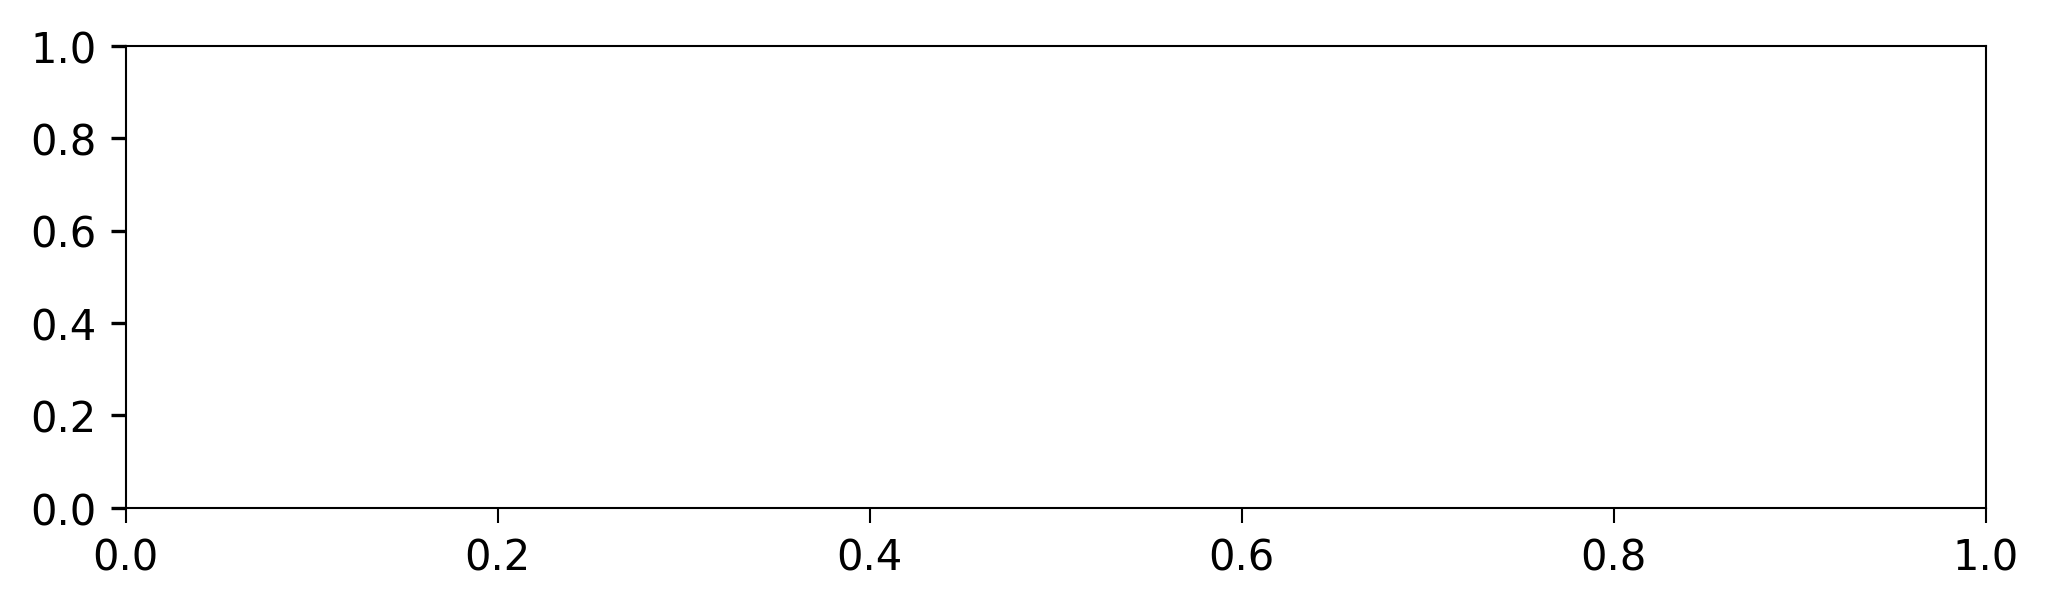

In [112]:
fig = plt.figure(figsize = (8,2))
axis = fig.add_subplot(111)
h = axis.hist(modules[0].bias.detach().numpy().flatten(), bins = 100)


In [ ]:
import networkx as nx
import torch_geometric.utils
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from ramannoodle.polarizability.gnn import _radius_graph_pbc
lattice, _, positions, _ = train_dataset[1]
plot_positions = {i: positions[i][0:2] for i, _ in enumerate(positions)}

edge_index, _, _ = _radius_graph_pbc(lattice.unsqueeze(0), positions.unsqueeze(0), cutoff = 2.5)
print(edge_index.size())
data = Data(x = positions, edge_index=edge_index)

g = torch_geometric.utils.to_networkx(data)
nx.draw(g, pos = plot_positions)

In [ ]:
for i in range(108):
    print(torch.sum(torch.where(torch.logical_or(edge_index[0] == i, edge_index[1] == i), 1, 0)))

In [18]:
import networkx as nx
import torch_geometric.utils
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
positions = torch.tensor([[0,0,0], [0,0.25,0.25], [0.75,0.75,0.75]])
plot_positions = {i: positions[i][0:2] for i, _ in enumerate(positions)}

edge_index = (  
    positions, r=2, max_num_neighbors=10
)
print(edge_index)
data = Data(x = positions, edge_index=edge_index)

g = torch_geometric.utils.to_networkx(data)
nx.draw(g, pos = plot_positions)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (4138222455.py, line 9)

In [ ]:

    
    # Construct fully graph from distance matrix and cutoff

# Can we make a fast pytorch version of this function?
# 1) get all distances, taking into account periodic boundary conditions.
# 2) apply cutoff to construct radius_graph
edge_index = structure_graph_pbc(, 0.3)

edge_index

In [ ]:
a = torch.tensor([[0, 1, 1, 0,3],
                  [1, 2, 2, 1,4]])
print(a)
dist_matrix = torch.randn((5,5))
print(dist_matrix)

In [ ]:
x = torch.randn((2,3,3))
print(x)
indices = torch.tensor([[0, 0], [1, 1], [2, 2], [0, 1], [0, 2], [1, 2]]).T
print(x[:, indices[0], indices[1]])

In [ ]:
import torch
from ramannoodle.polarizability.gnn import _radius_graph_pbc

_radius_graph_pbc(
    torch.eye(3)*1,
    torch.tensor([[0,0,0],[0.7,0,0],[0.50,0.20,0]]),
    cutoff = 2
)

In [50]:
from ramannoodle.polarizability.gnn import _get_rotations

rot = _get_rotations(torch.tensor([[2.0,2.0,2]]))


In [51]:
p = torch.tensor([[[6.0,0,0],[0,6,0],[0,0,5]]])

In [53]:
torch.linalg.inv(rot) @ p @ rot

tensor([[[ 5.6667,  0.1220, -0.4553],
         [ 0.1220,  5.9553,  0.1667],
         [-0.4553,  0.1667,  5.3780]]])

In [14]:
from ramannoodle.polarizability.gnn import GaussianFilter

module = GaussianFilter(0, 5, 50)

module(torch.tensor(2.8))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.9693e-40, 2.4871e-34, 3.8121e-29, 2.1495e-24,
         4.4590e-20, 3.4027e-16, 9.5526e-13, 9.8657e-10, 3.7483e-07, 5.2390e-05,
         2.6938e-03, 5.0956e-02, 3.5459e-01, 9.0774e-01, 8.5488e-01, 2.9618e-01,
         3.7749e-02, 1.7700e-03, 3.0530e-05, 1.9373e-07, 4.5224e-10, 3.8838e-13,
         1.2270e-16, 1.4261e-20, 6.0971e-25, 9.5903e-30, 5.5494e-35, 1.1813e-40,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])

In [21]:
diag = torch.randn((2,3,3))
off_diag = torch.randn((2,3,3))

edge_polarizability = diag * torch.eye(3) + off_diag * -(torch.eye(3) - 1)

tensor(3.0307)
tensor(1.3659)


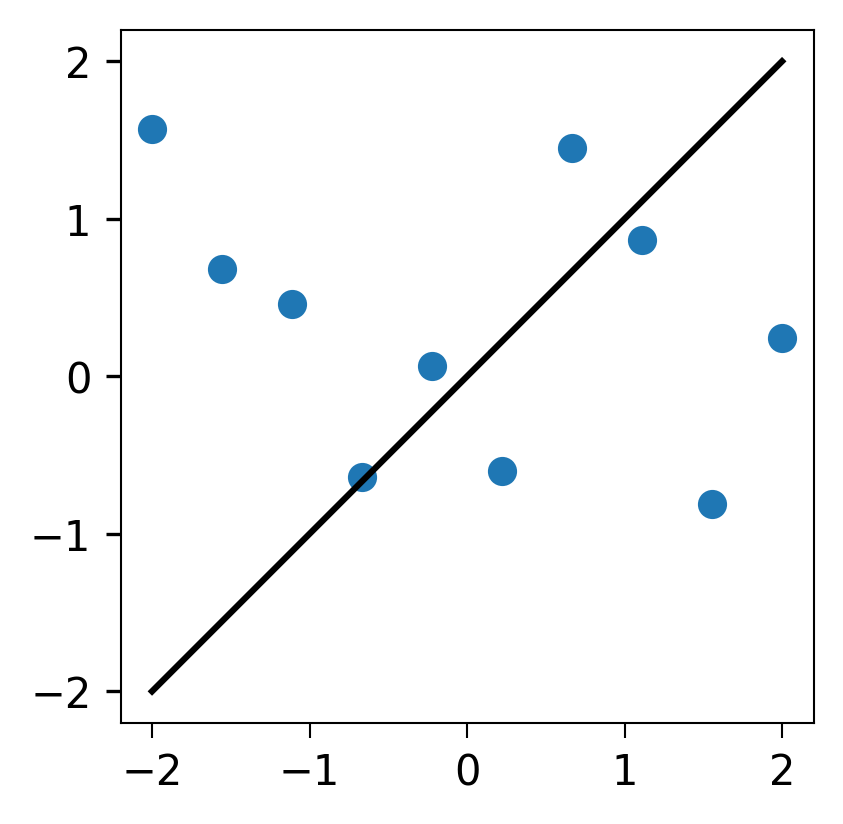

In [147]:
out = torch.randn(10)
target = torch.linspace(-2,2,10)

fig = plt.figure(figsize = (3,3))
axis = fig.add_subplot(111)
axis.scatter(target,out)
axis.plot([-2,2],[-2,2], color = 'black')
axis.set_aspect(1)
print(torch.nn.MSELoss()(out,target))
print(torch.nn.L1Loss()(out,target))